In [109]:
%load_ext autoreload
%autoreload 2

import os, sys
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

sys.path.insert(1, os.path.join(sys.path[0], ".."))
from reproduction.pipeline.load import load_data
from reproduction import analysis

In [112]:
import sklearn

In [2]:
# Here is the casper's settings
#===============================================
#OPENS = "../data/open-recs/*.tfrecord"
#CLOSEDS = "../data/closed-recs/*.tfrecord"
#CENTERS = "../output/m15b-enc.cluster_centres"
#ENCODER_DEF = "../output/mod09cnn15b/encoder.json"
#ENCODER_WEIGHTS = "../output/mod09cnn15b/encoder-585000.h5"
#ENCODINGS = "../output/mod09cnn15b/m15b-enc"

In [95]:
# open/closed cell data dir
CLOSEDATADIR="/home/tkurihana/scratch-midway2/clouds/2017JAN01MOD09GA_close"
CLOSEDS = CLOSEDATADIR+"/closed.tfrecord"
OPENDATADIR="/home/tkurihana/scratch-midway2/clouds/2017JAN01MOD09GA_open"
OPENS = OPENDATADIR+"/open.tfrecord"

# casper's setting
#DATADIR="/project/foster/clouds/data"
#OPENS = DATADIR+"/open_cell-128x500m/open.tfrecord"
#CLOSEDS = DATADIR+"/closed_cell-128x500m/closed.tfrecord"

# outputdata dir
OUTPUTDIR="/project/foster/clouds/output"
CENTERS = OUTPUTDIR+"/mod09cnn15b/encodings/m15b-enc.cluster_centres"
ENCODER_DEF = OUTPUTDIR+"/mod09cnn15b/encoder.json"
ENCODER_WEIGHTS = OUTPUTDIR+"/mod09cnn15b/encoder-585000.h5"
ENCODINGS = OUTPUTDIR+"/mod09cnn15b/encodings/m15b-enc"

In [96]:
centers = analysis.read_kmeans_centers(CENTERS)

In [97]:
k = KMeans(n_clusters=centers.shape[0], init=centers)

In [98]:
with open(ENCODER_DEF,"r") as f:
    encoder = tf.keras.models.model_from_json(f.read())
encoder.load_weights(ENCODER_WEIGHTS)

#### Tak version

In [69]:
encoder.input_shape[1:]

(128, 128, 7)

In [70]:
load_data(OPENS, encoder.input_shape[1:])

<PrefetchDataset shapes: ((32,), (32, 2), (32, 128, 128, 7)), types: (tf.string, tf.int64, tf.float32)>

#### Casper's version

In [19]:
encoder.input_shape[1:]

(128, 128, 7)

In [20]:
load_data(OPENS, encoder.input_shape[1:])

<PrefetchDataset shapes: ((32,), (32, 2), (32, 128, 128, 7)), types: (tf.string, tf.int64, tf.float32)>

#### ==> same dimension

## Inside of AEData

In [71]:
batch = load_data(OPENS, encoder.input_shape[1:]).make_one_shot_iterator().get_next()

In [45]:
type(batch)

tuple

In [77]:
np_batch = np.asarray(batch)
np_batch.shape
for i in np_batch:
    print(i)

Tensor("IteratorGetNext_10:0", shape=(32,), dtype=string)
Tensor("IteratorGetNext_10:1", shape=(32, 2), dtype=int64)
Tensor("IteratorGetNext_10:2", shape=(32, 128, 128, 7), dtype=float32)


In [99]:
opens = analysis.AEData(load_data(OPENS, encoder.input_shape[1:]), n=5000)
closeds = analysis.AEData(load_data(CLOSEDS, encoder.input_shape[1:]), n=5000)

In [100]:
opens.add_encoder(encoder)
closeds.add_encoder(encoder)

In [101]:
k.cluster_centers_ = centers

In [102]:
o = k.predict(opens.encs)
c = k.predict(closeds.encs)

## Cluster consistency

In [103]:
both = np.append(opens.encs,closeds.encs, axis=0)

clusters_km = k.predict(both)
clusters_km2 = KMeans(n_clusters=60).fit_predict(both)
clusters_km3 = KMeans(n_clusters=60).fit_predict(both)
clusters_ag = AgglomerativeClustering(n_clusters=60).fit_predict(both)

In [104]:
clusters_sc = SpectralClustering(n_clusters=60, affinity="nearest_neighbors").fit_predict(both)
clusters_sc2 = SpectralClustering(n_clusters=60, affinity="nearest_neighbors").fit_predict(both)

/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [105]:
perm = np.random.permutation(10000)
inv_perm = np.argsort(perm)

clusters_ag2 = AgglomerativeClustering(n_clusters=60).fit_predict(both[perm])
clusters_ag2 = clusters_ag2[inv_perm]


In [106]:
def compare_clusters(a, b):
    plt.figure(figsize=(5,4))
    h = plt.hist2d(a, b, bins=60, norm=LogNorm())
    plt.colorbar(h[3] )
    plt.xlabel("A")
    plt.ylabel("B")
    amis = sklearn.metrics.adjusted_mutual_info_score(a, b)
    plt.title("Adjusted information score %f"%amis)

## Caper's case 

/anaconda3/envs/clouds/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


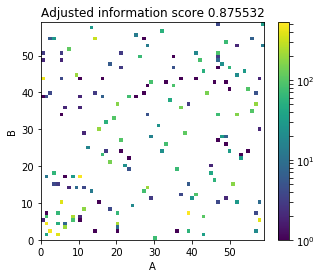

In [274]:
compare_clusters(clusters_sc, clusters_sc2)

## My try-case (2017JAN01)

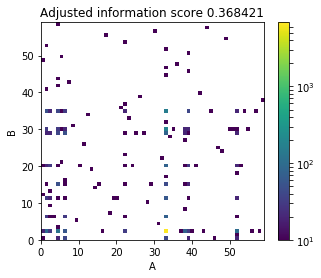

In [113]:
compare_clusters(clusters_sc, clusters_sc2)

# Open v Closed

In [114]:
num_clusters = 40
method = SpectralClustering(n_clusters=num_clusters, affinity="nearest_neighbors")
clusters = method.fit_predict(both)

/home/tkurihana/.conda/envs/py3501/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


## Casper's graph

(array([1664., 1854.,  849., 1182.,  440.,  319., 1246.,  603.,  511.,
        1332.]),
 array([ 0. ,  3.9,  7.8, 11.7, 15.6, 19.5, 23.4, 27.3, 31.2, 35.1, 39. ]),
 <a list of 10 Patch objects>)

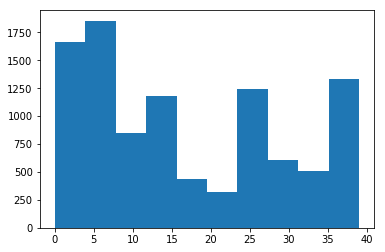

In [327]:
plt.hist(clusters)

## My try-case

(array([8644.,   40.,  130.,  208.,   40.,   40.,   40.,   40.,  113.,
         705.]),
 array([ 0. ,  3.9,  7.8, 11.7, 15.6, 19.5, 23.4, 27.3, 31.2, 35.1, 39. ]),
 <a list of 10 Patch objects>)

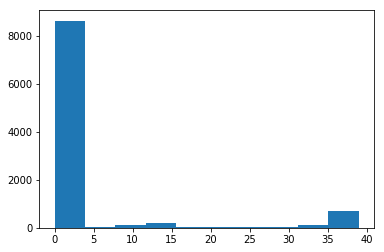

In [115]:
plt.hist(clusters)

In [116]:
o, c = clusters[:5000], clusters[5000:]
true_labels = np.zeros(10000)
true_labels[:5000] += 1

In [117]:
# Probability you correctly classify open vs closed given cluster assignments
correctness = 0
for i in range(60):
    # Add one open and closed cell to every class to increase uncertainty
    # in clusters with few examples
    n_open = np.where(o == i)[0].shape[0] + 1
    n_clos = np.where(c == i)[0].shape[0] + 1
    n_clus = n_open + n_clos
    
    prob_open = n_open / n_clus
    correctness += n_clus * max(prob_open, 1 - prob_open)
    
correctness /= 10000
correctness

0.5271

## Fixed version by Tak??

In [120]:
# Probability you correctly classify open vs closed given cluster assignments
correctness = 0
for i in range(60):
    # Add one open and closed cell to every class to increase uncertainty
    # in clusters with few examples
    n_open = np.where(o == i)[0].shape[0] + 1
    n_clos = np.where(c == i)[0].shape[0] + 1
    n_clus = n_open + n_clos
    
    prob_open = n_open / n_clus
    prob_clos = 1.0 - prob_open 
    correctness += n_clus * max(prob_open, 1 - prob_open)
    
correctness /= 10000
correctness

0.5271

In [121]:
print(" Probaility of Open-Cell == %f " %prob_open)

 Probaility of Open-Cell == 0.500000 


In [123]:
print(" Probaility of Close-Cell == %f " %prob_clos)

 Probaility of Close-Cell == 0.500000 


In [125]:
print(" Number of Clus == %f " %n_clus)
print(" Number of Open == %f " %n_open)
print(" Number of Clos == %f " %n_clos)

 Number of Clus == 2.000000 
 Number of Open == 1.000000 
 Number of Clos == 1.000000 


# Important Graphs

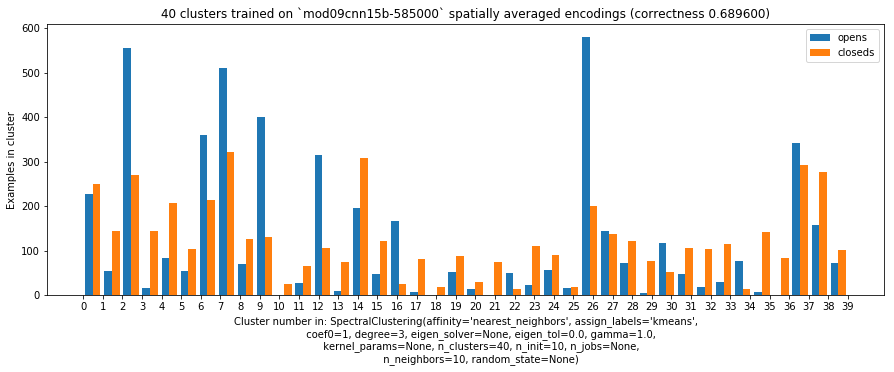

In [330]:
plt.figure(figsize=(15, 5))
plt.hist([o,c], bins=num_clusters, label=["opens", "closeds"])
plt.xlabel("Cluster number in: "+str(method))
plt.xticks(range(num_clusters))
plt.ylabel("Examples in cluster")
plt.title("%d clusters trained on `mod09cnn15b-585000` spatially averaged encodings (correctness %f)"%(num_clusters, correctness))
plt.legend()

## My try-case

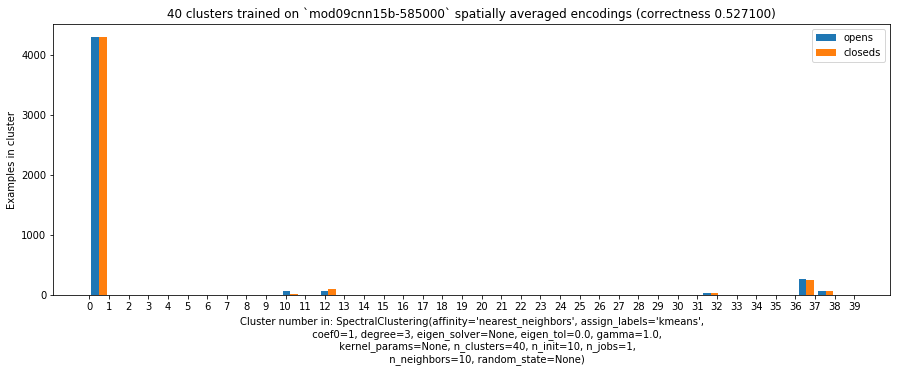

In [118]:
plt.figure(figsize=(15, 5))
plt.hist([o,c], bins=num_clusters, label=["opens", "closeds"])
plt.xlabel("Cluster number in: "+str(method))
plt.xticks(range(num_clusters))
plt.ylabel("Examples in cluster")
plt.title("%d clusters trained on `mod09cnn15b-585000` spatially averaged encodings (correctness %f)"%(num_clusters, correctness))
plt.legend()

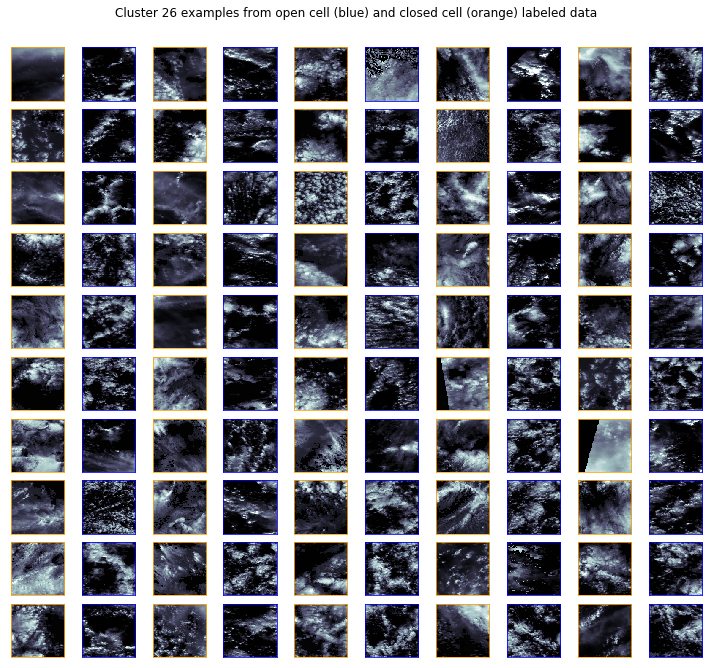

In [334]:
cluster_num = 26
rows, cols = 10, 10

fig, ax = plt.subplots(rows, cols, figsize=(cols, rows))

for a in ax.ravel():
    a.set_xticks([])
    a.set_yticks([])
    a.set_frame_on(b=4)

for i, a in enumerate(ax.ravel()):
    s = opens.imgs[o == cluster_num] if i % 2 else closeds.imgs[c == cluster_num]
    a.imshow(s[i // 2, :, :, 0], cmap="bone")
    for pos in a.spines:
        a.spines[pos].set_edgecolor("blue" if i % 2 else "orange")

        
fig.suptitle("Cluster %d examples from open cell (blue) and closed cell (orange) labeled data" % cluster_num);
fig.subplots_adjust(top=2.5)
fig.tight_layout()

## My try-case

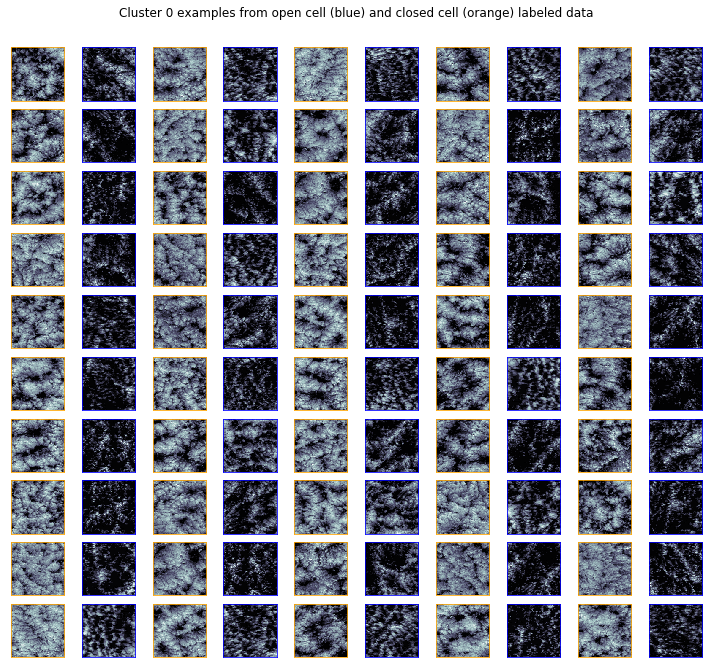

In [119]:
cluster_num = 0
rows, cols = 10, 10

fig, ax = plt.subplots(rows, cols, figsize=(cols, rows))

for a in ax.ravel():
    a.set_xticks([])
    a.set_yticks([])
    a.set_frame_on(b=4)

for i, a in enumerate(ax.ravel()):
    s = opens.imgs[o == cluster_num] if i % 2 else closeds.imgs[c == cluster_num]
    a.imshow(s[i // 2, :, :, 0], cmap="bone")
    for pos in a.spines:
        a.spines[pos].set_edgecolor("blue" if i % 2 else "orange")

        
fig.suptitle("Cluster %d examples from open cell (blue) and closed cell (orange) labeled data" % cluster_num);
fig.subplots_adjust(top=2.5)
fig.tight_layout()

## Casper's case

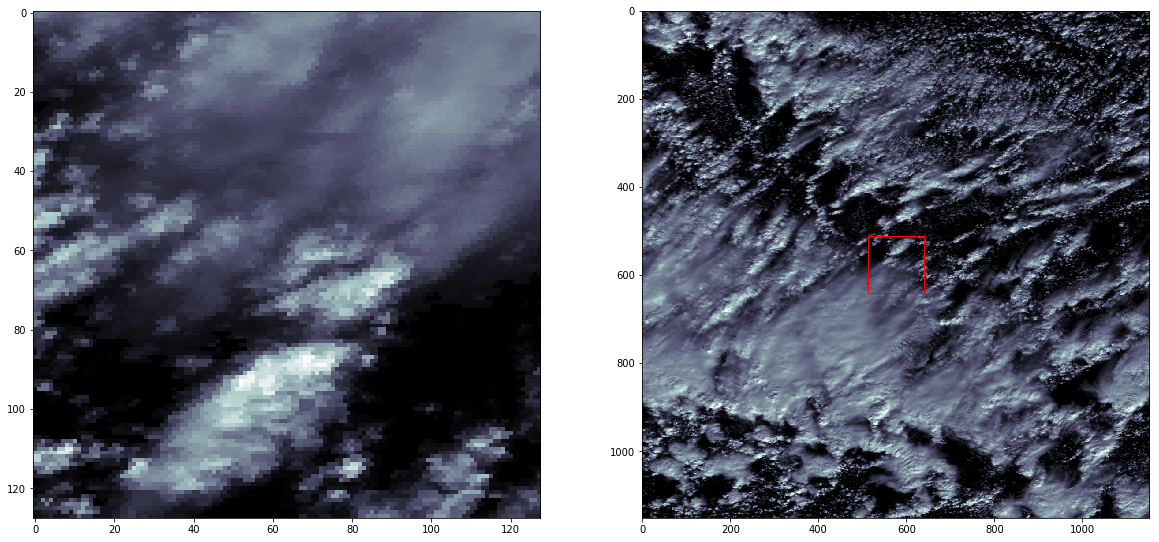

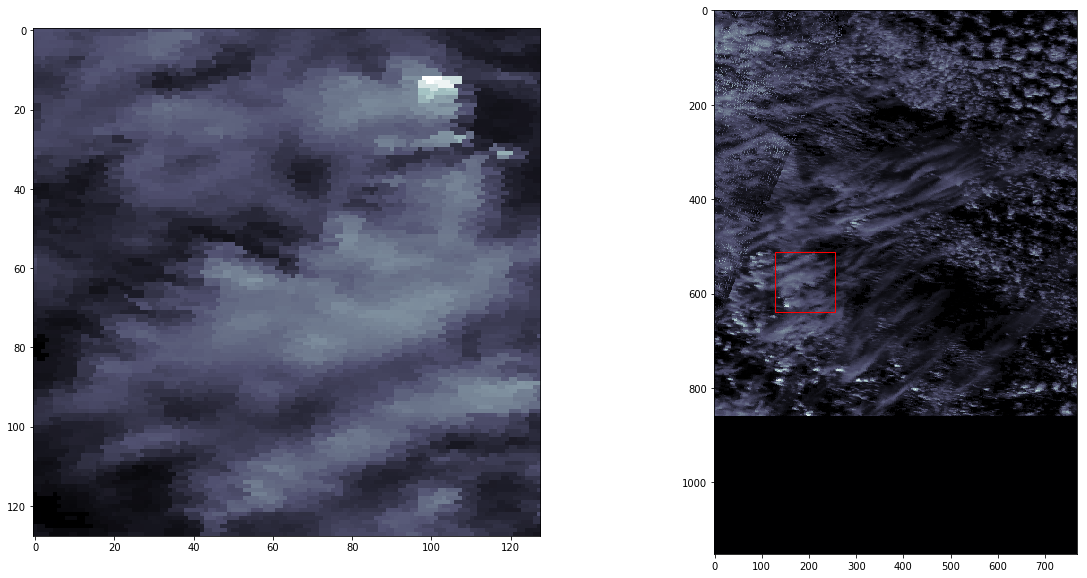

In [75]:
cluster = 9

i = np.argwhere(o == cluster)[0,0]
j = np.argwhere(c == cluster)[0,0]

opens.plot_neighborhood(i,context_width=512)
closeds.plot_neighborhood(j,context_width=512)

## My case

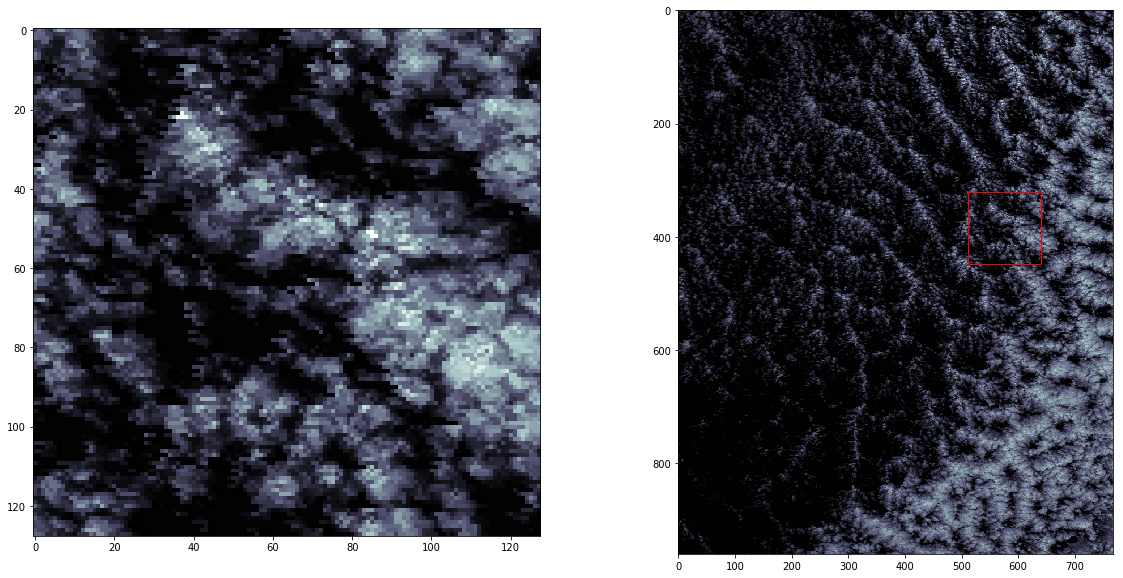

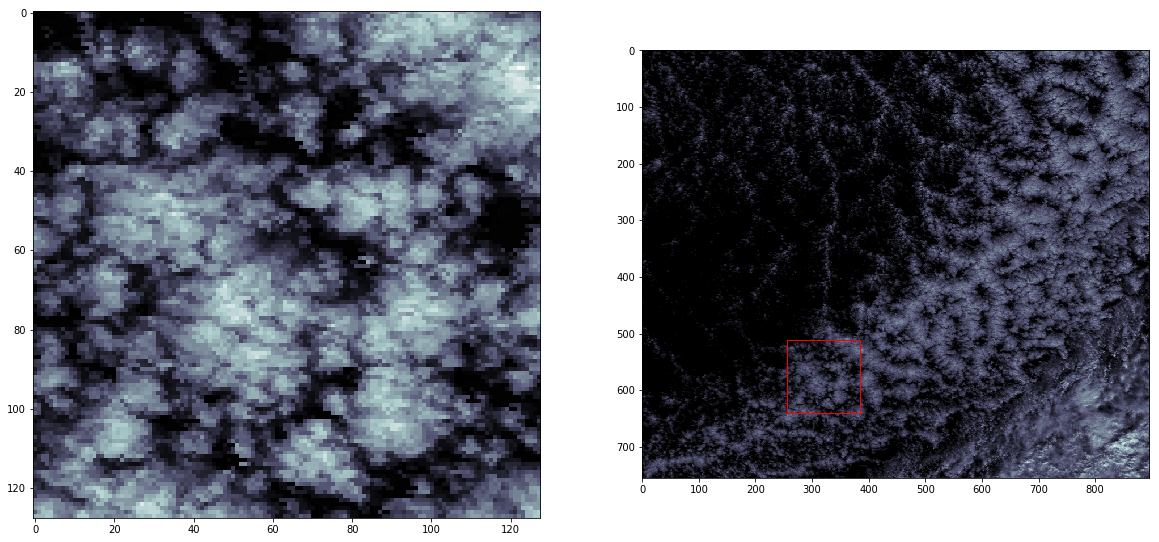

In [126]:
cluster = 0

i = np.argwhere(o == cluster)[0,0]
j = np.argwhere(c == cluster)[0,0]

opens.plot_neighborhood(i,context_width=512)
closeds.plot_neighborhood(j,context_width=512)